In [1]:
# import the librarie
import numpy as np
import pandas as pd

# for plot
import matplotlib.pyplot as plt

# normalize date
from sklearn.preprocessing import MinMaxScaler

# check the error of the model
from sklearn.metrics import mean_squared_error

# libraries for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

### Import Dataset

In [32]:
# import our data frame
df = pd.read_csv("gold.csv", index_col="date", parse_dates=["date"])

C:\Users\user\AppData\Local\Temp\ipykernel_15540\609735875.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv("gold.csv", index_col="date", parse_dates=["date"])


In [33]:
df.head()

,open,max,min,close
date,,,,
2009-01-12,1179.40,1201.32,1175.23,1195.23
2009-02-12,1195.65,1216.90,1195.30,1215.10
2009-03-12,1215.15,1226.37,1204.28,1207.60
2009-04-12,1207.80,1212.24,1147.32,1160.82
2009-05-12,1159.43,1164.62,1135.53,1157.70


In [50]:
# convert date object into datetime
# df['date'] = pd.to_datetime(df['date'])

In [53]:
# set date as index
# df.set_index('date', drop=True, inplace=True)

### Preprocess Dataset

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3442 entries, 2009-01-12 to 2019-04-05
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3442 non-null   float64
 1   max     3442 non-null   float64
 2   min     3442 non-null   float64
 3   close   3442 non-null   float64
dtypes: float64(4)
memory usage: 134.5 KB


In [36]:
df.describe()

,open,max,min,close
count,3442.000000,3442.000000,3442.000000,3442.000000
mean,1453.530532,1463.665546,1443.072629,1453.646830
std,252.942917,255.027925,250.254596,252.918611
min,1050.740000,1063.430000,1044.460000,1050.870000
25%,1244.265000,1253.157500,1237.907500,1244.627500
50%,1343.840000,1352.635000,1333.070000,1344.605000
75%,1699.922500,1714.752500,1686.575000,1700.392500
max,2061.080000,2071.540000,2031.310000,2059.580000


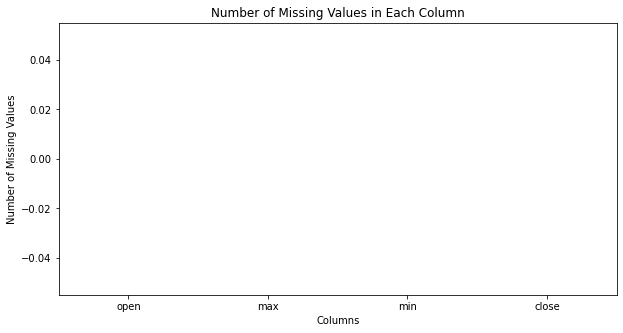

In [37]:
# check for missing values
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of missing values in each column
missing = df.isnull().sum()

# Plot the number of missing values in each column
plt.figure(figsize=(10,5))
sns.barplot(x=missing.index, y=missing.values)

# Add labels and title to the plot
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.title("Number of Missing Values in Each Column")

# Show the plot
plt.show()

### Visualize the dataset

In [38]:
df.describe()

,open,max,min,close
count,3442.000000,3442.000000,3442.000000,3442.000000
mean,1453.530532,1463.665546,1443.072629,1453.646830
std,252.942917,255.027925,250.254596,252.918611
min,1050.740000,1063.430000,1044.460000,1050.870000
25%,1244.265000,1253.157500,1237.907500,1244.627500
50%,1343.840000,1352.635000,1333.070000,1344.605000
75%,1699.922500,1714.752500,1686.575000,1700.392500
max,2061.080000,2071.540000,2031.310000,2059.580000


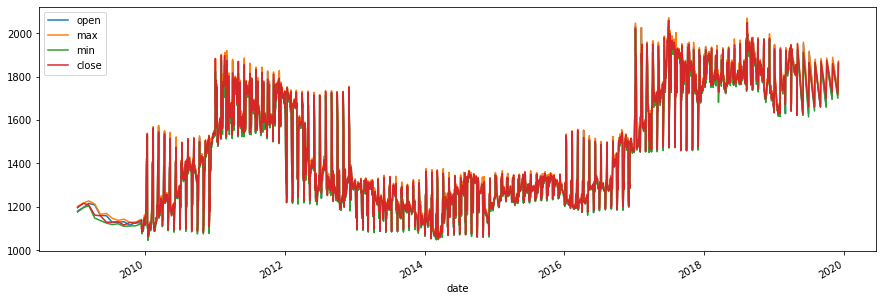

In [39]:
df.plot(figsize=(15, 5))
plt.show()

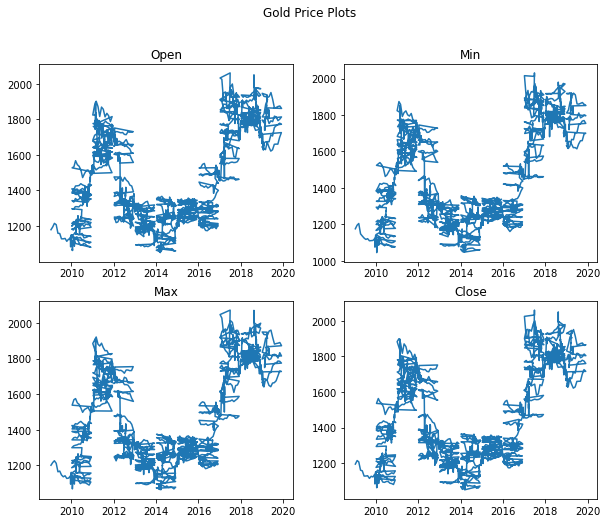

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
index = df.index
open_data = df['open']
min_data = df['min']
max_data = df['max']
close_data = df['close']

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot the data on each subplot
axs[0, 0].plot(index, open_data)
axs[0, 0].set_title('Open')

axs[0, 1].plot(index, min_data)
axs[0, 1].set_title('Min')

axs[1, 0].plot(index, max_data)
axs[1, 0].set_title('Max')

axs[1, 1].plot(index, close_data)
axs[1, 1].set_title('Close')

# Add a main title to the figure
fig.suptitle('Gold Price Plots')

# Display the figure
plt.show()


### Create Model

In [49]:
def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "max"].plot(
    figsize=(16, 4), legend=True)
    
    dataset.loc[f"{tend}":, "max"].plot(
        figsize=(16, 4), legend=True
    )
    
    plt.legend([f"Train (Before {tend})",f"Test ({tend} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

In [43]:
df.head(14)

,open,max,min,close
date,,,,
2009-01-12,1179.40,1201.32,1175.23,1195.23
2009-02-12,1195.65,1216.90,1195.30,1215.10
2009-03-12,1215.15,1226.37,1204.28,1207.60
2009-04-12,1207.80,1212.24,1147.32,1160.82
2009-05-12,1159.43,1164.62,1135.53,1157.70
2009-06-12,1158.10,1168.47,1124.32,1128.10
2009-07-12,1128.25,1146.85,1116.75,1128.20
2009-08-12,1128.15,1136.49,1120.90,1129.90
2009-09-12,1130.49,1142.13,1109.36,1115.10


In [44]:
df.tail(14)

,open,max,min,close
date,,,,
2019-04-21,1825.02,1833.32,1816.90,1821.80
2019-04-22,1821.78,1827.34,1808.49,1810.52
2019-04-23,1810.42,1819.66,1806.16,1816.63
2019-04-24,1816.64,1830.70,1804.31,1826.45
2019-04-25,1826.48,1844.09,1822.60,1836.18
2019-04-26,1836.55,1838.46,1829.52,1835.28
2019-04-27,1835.42,1856.71,1835.16,1855.96
2019-04-28,1854.42,1857.81,1844.66,1846.30
2019-04-29,1846.33,1851.18,1812.18,1813.09


C:\Users\user\AppData\Local\Temp\ipykernel_15540\963217976.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  dataset.loc[f"{tstart}":f"{tend}", "max"].plot(


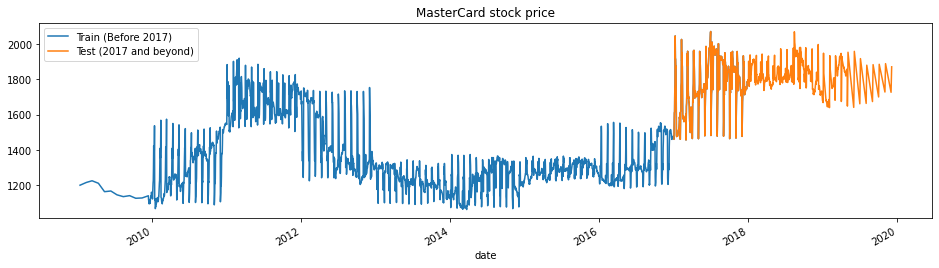

In [50]:
tstart = 2009
tend = 2017
train_test_plot(df, tstart, tend)

In [52]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}","max"].values
    test = dataset.loc[f"{tend+1}":, "max"].values
    return train, test

In [54]:
training_set, test_set = train_test_split(df, tstart, tend)

C:\Users\user\AppData\Local\Temp\ipykernel_15540\1332193188.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train = dataset.loc[f"{tstart}":f"{tend}","max"].values


In [55]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [56]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [57]:
n_steps = 60
# divizăm in pasi
X_train, y_train = split_sequence(training_set_scaled,n_steps)

In [58]:
# Remodelarea X_train pentru model
features = 1
X_train.reshape(X_train.shape[0],X_train.shape[1],features)

array([[[0.13678071],
        [0.15223537],
        [0.16162919],
        ...,
        [0.06677843],
        [0.05703743],
        [0.04415193]],

       [[0.15223537],
        [0.16162919],
        [0.14761286],
        ...,
        [0.05703743],
        [0.04415193],
        [0.04514388]],

       [[0.16162919],
        [0.14761286],
        [0.10037595],
        ...,
        [0.04415193],
        [0.04514388],
        [0.05482537]],

       ...,

       [[0.78288084],
        [0.79374275],
        [0.80521967],
        ...,
        [0.7141185 ],
        [0.72029838],
        [0.71077561]],

       [[0.79374275],
        [0.80521967],
        [0.80146016],
        ...,
        [0.72029838],
        [0.71077561],
        [0.72782732]],

       [[0.80521967],
        [0.80146016],
        [0.79378242],
        ...,
        [0.71077561],
        [0.72782732],
        [0.72809515]]])

In [59]:
# Arhitectura
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))

# Compilarea modelului
model_lstm.compile(optimizer="RMSprop", loss="mse")

In [60]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [61]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
91/91 [==============================] - 4s 29ms/step - loss: 0.0048
Epoch 2/50
91/91 [==============================] - 3s 34ms/step - loss: 0.0014
Epoch 3/50
91/91 [==============================] - 3s 33ms/step - loss: 9.2224e-04
Epoch 4/50
91/91 [==============================] - 3s 36ms/step - loss: 7.8768e-04
Epoch 5/50
91/91 [==============================] - 4s 40ms/step - loss: 7.0848e-04
Epoch 6/50
91/91 [==============================] - 5s 52ms/step - loss: 5.6206e-04
Epoch 7/50
91/91 [==============================] - 5s 57ms/step - loss: 5.4287e-04
Epoch 8/50
91/91 [==============================] - 5s 58ms/step - loss: 4.9306e-04
Epoch 9/50
91/91 [==============================] - 5s 54ms/step - loss: 4.3877e-04
Epoch 10/50
91/91 [==============================] - 5s 51ms/step - loss: 4.1794e-04
Epoch 11/50
91/91 [==============================] - 5s 57ms/step - loss: 4.1342e-04
Epoch 12/50
91/91 [==============================] - 5s 58ms/step - loss: 3.7728e-

In [63]:
dataset_total = df.loc[:,"max"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)
# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],features)

In [64]:
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [69]:
def plot_predictions(test, predicted):
    fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size to 16 x 8
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("GLod Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

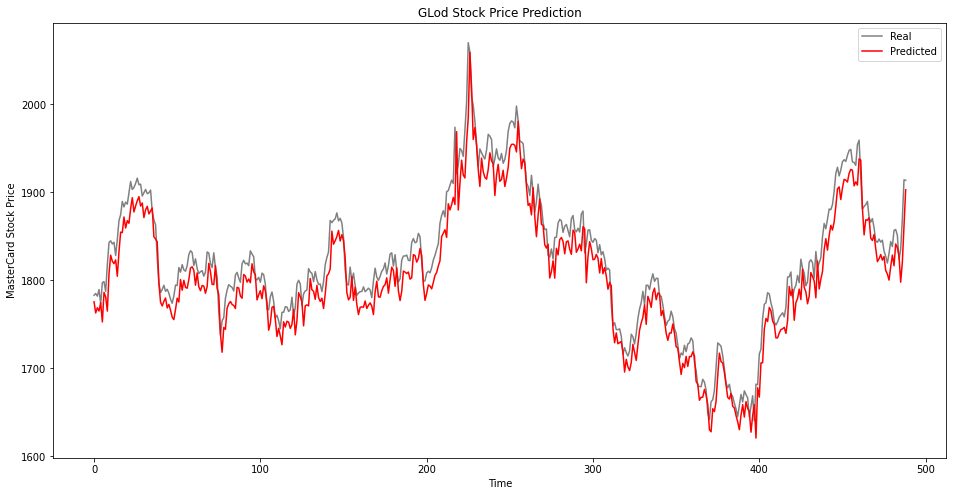

In [70]:
plot_predictions(test_set,predicted_stock_price)

### Evaluate the model

In [66]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

In [68]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 23.91.


In [73]:
# mean absolute error
from sklearn.metrics import mean_absolute_error

def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
#     rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The mean absolute error is {:.2f}.".format(mae))

In [74]:
return_mae(test_set,predicted_stock_price)

The mean absolute error is 20.19.


In [76]:
# r-squared error
from sklearn.metrics import r2_score

def return_r2_score(test, predicted):
    r2 = r2_score(test, predicted)
    print("The r2 error is {:.2f}.".format(r2))

return_r2_score(test_set,predicted_stock_price)


The r2 error is 0.90.


### Conclusion

The R-squared (R2) score is a statistical measure that represents the proportion of variance in the dependent variable that is explained by the independent variables in a regression model. The R2 score ranges from 0 to 1, where 0 indicates that the model does not explain any of the variance in the dependent variable, and 1 indicates that the model perfectly explains all of the variance in the dependent variable.

However, as a general rule of thumb, an R2 score of 0.7 or higher is often considered to be a good fit for many practical applications. It indicates that the model explains a significant portion of the variance in the dependent variable, and can be used to make reliable predictions. On the other hand, an R2 score below 0.5 may indicate that the model is not a good fit for the data, and its predictions should be treated with caution.

The Mean Squared Error (MSE) and Mean Absolute Error (MAE) are commonly used metrics to evaluate the performance of regression models.

The MSE is the average of the squared differences between the predicted values and the actual values. It is calculated by taking the sum of the squared errors and dividing it by the number of samples in the dataset. The units of MSE are the square of the units of the original data. A lower MSE indicates better model performance.

The MAE is the average of the absolute differences between the predicted values and the actual values. It is calculated by taking the sum of the absolute errors and dividing it by the number of samples in the dataset. The units of MAE are the same as the units of the original data. A lower MAE indicates better model performance.

There is no fixed "normal" MSE or MAE that can be used as a benchmark to evaluate the performance of a model. The acceptable values for MSE and MAE can vary depending on the context of the problem, the size of the dataset, and the quality of the data. However, as a general rule of thumb, a lower MSE or MAE is better, and it is often useful to compare the MSE and MAE of different models to choose the best one.

### Download the dateset

In [77]:
import tensorflow as tf

# save the model to a file
tf.saved_model.save(model_lstm, 'model')


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [78]:
model_lstm.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [80]:
import pickle

# Load your trained model
# model_lstm

# Save the model as a pkl file
with open('my_model.pkl', 'wb') as file:
    pickle.dump(model_lstm, file)


INFO:tensorflow:Assets written to: ram://a817df17-2cff-4ad3-9831-de265dfa42cc/assets


INFO:tensorflow:Assets written to: ram://a817df17-2cff-4ad3-9831-de265dfa42cc/assets
